# CS6140 Assignment 4: Unsupervised Learning FMA data Part 2
- Student: Sukhrobbek Ilyosbekov

**Table of Contents**

1. [Data Preparation](#1)
2. [Dimension Reduction Techniques](#2)
    1. [Principal Component Analysis (PCA)](#2.1)
    2. [Uniform Manifold Approximation and Projection (UMAP)](#2.2)
    3. [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#2.3)
    4. [Locally Linear Embedding (LLE)](#2.4)
    5. [ISOMAP](#2.5)
3. [Visualization](#3)
4. [Correlation Analysis](#4)
5. [Comparative Analysis](#5)

## Setup
In order to run this notebook, the following libraries should be installed:
- pandas
- matplotlib
- seaborn
- umap-learn
- scikit-learn

These libraries can be installed using the following command:
```bash
pip install pandas matplotlib seaborn numba umap-learn scikit-learn
```

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_data_path(relative_path: str) -> str:
    """
    Get the absolute path to a file in the `dataset` directory.

    Args:
        relative_path: The path to the file relative to the `dataset` directory including the file name.

    Returns:
        The full path to the file in the `dataset` directory.

    Examples:
        >>> get_data_path("assignment1/boston_listings.csv")
        "C:/Users/username/assignments/dataset/assignment1/boston_listings.csv"
    """
    return os.path.abspath(os.path.join("../../dataset", relative_path))

## Data Preparation <a class="anchor" id="1"></a>

First, load the features dataset and standardize column names since it has multi-level column names.

In [2]:
# Load the features dataset
features_df = pd.read_csv(get_data_path("assignment4/features.csv"), header=[0, 1, 2, 3])

# Flatten the multi-row header to create a single-level column index for easier manipulation
features_df.columns = ["_".join(filter(None, col)).strip() for col in features_df.columns.values]

# Remove "_Unnamed: 1_level_3", "_Unnamed: 2_level_3" and so on using regex
features_df.columns = features_df.columns.str.replace(r"_Unnamed: \d+_level_\d+$", "", regex=True)

# Rename the column feature_statistics_number_track_id to track_id
features_df.rename(columns={"feature_statistics_number_track_id": "track_id"}, inplace=True)

print("Features dataset info:")
display(features_df.info())

print("First few rows of the features dataset:")
display(features_df.head())

Features dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


None

First few rows of the features dataset:


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,...,tonnetz_max_04,tonnetz_max_05,tonnetz_max_06,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,tonnetz_median_01,tonnetz_median_02,tonnetz_median_03,tonnetz_median_04,tonnetz_median_05,tonnetz_median_06,tonnetz_min_01,tonnetz_min_02,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,...,0.318972,0.059690,0.069184,-0.002570,0.019296,0.010510,0.073464,0.009272,0.015765,-0.003789,0.017786,0.007311,0.067945,0.009488,0.016876,-0.059769,-0.091745,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,1.038253,1.292235,0.677641,0.584248,0.581271,0.581182,0.454241,0.464841,0.542833,0.664720,0.511329,0.530998,0.603398,0.547428,0.232784,0.229469,0.225674,0.216713,0.220512,0.242744,0.369235,0.420716,0.312129,0.242748,0.264292,0.225683,0.230579,0.228059,0.209370,...,0.214807,0.070261,0.070394,0.000183,0.006908,0.047025,-0.029942,0.017535,-0.001496,-0.000108,0.007161,0.046912,-0.021149,0.016299,-0.002657,-0.097199,-0.079651,-0.164613,-0.304375,-0.024958,-0.055667,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,0.268932,1.125141,0.611014,0.651471,0.494528,0.448799,0.468624,0.454021,0.497172,0.559755,0.671287,0.610565,0.551663,0.603413,0.258420,0.303385,0.250737,0.218562,0.245743,0.236018,0.275766,0.293982,0.346324,0.289821,0.246368,0.220939,0.255472,0.293571,0.245253,...,0.180027,0.072169,0.076847,-0.007501,-0.018525,-0.030318,0.024743,0.004771,-0.004536,-0.007385,-0.018953,-0.020358,0.024615,0.004868,-0.003899,-0.128391,-0.125289,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,4.326824,1.300406,0.461840,0.540411,0.446708,0.647553,0.591908,0.513306,0.651501,0.516887,0.511479,0.478263,0.638766,0.638495,0.229882,0.286978,0.240096,0.226792,0.192443,0.288410,0.413348,0.349137,0.268424,0.243144,0.268941,0.236763,0.230555,0.280229,0

Extract domain features and save them in a separate dataframe. Since the features are already normalized, we don"t need to normalize them again.

In [3]:
# Select domains for dimensionality reduction
domains_to_extract = ["chroma", "mfcc", "spectral", "tonnetz"]

# Initialize a list to hold the extracted columns
extracted_columns = []

# Loop through the columns and filter based on the selected domains
for col in features_df.columns:
    for domain in domains_to_extract:
        if domain in col:
            extracted_columns.append(col)
            break

# Modify the features dataframe to include only the extracted columns
features_extracted_df = features_df[extracted_columns]

# Display the shape and a preview of the extracted features
print("Shape of extracted features for selected domains:", features_extracted_df.shape)
display(features_extracted_df.head())

Shape of extracted features for selected domains: (106574, 504)


,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,...,tonnetz_kurtosis_03,tonnetz_kurtosis_04,tonnetz_kurtosis_05,tonnetz_kurtosis_06,tonnetz_max_01,tonnetz_max_02,tonnetz_max_03,tonnetz_max_04,tonnetz_max_05,tonnetz_max_06,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,tonnetz_median_01,tonnetz_median_02,tonnetz_median_03,tonnetz_median_04,tonnetz_median_05,tonnetz_median_06,tonnetz_min_01,tonnetz_min_02,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06
0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,0.238187,...,1.033038,1.668363,0.829119,8.464136,0.103562,0.160202,0.209170,0.318972,0.059690,0.069184,-0.002570,0.019296,0.010510,0.073464,0.009272,0.015765,-0.003789,0.017786,0.007311,0.067945,0.009488,0.016876,-0.059769,-0.091745,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111
1,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,1.038253,1.292235,0.677641,0.584248,0.581271,0.581182,0.454241,0.464841,0.542833,0.664720,0.511329,0.530998,0.603398,0.547428,0.232784,0.229469,0.225674,0.216713,0.220512,0.242744,0.369235,0.420716,0.312129,0.242748,0.264292,0.225683,0.230579,0.228059,0.209370,0.202267,...,0.865467,2.015784,0.429529,0.480131,0.178571,0.114781,0.268787,0.214807,0.070261,0.070394,0.000183,0.006908,0.047025,-0.029942,0.017535,-0.001496,-0.000108,0.007161,0.046912,-0.021149,0.016299,-0.002657,-0.097199,-0.079651,-0.164613,-0.304375,-0.024958,-0.055667,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740
2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,0.268932,1.125141,0.611014,0.651471,0.494528,0.448799,0.468624,0.454021,0.497172,0.559755,0.671287,0.610565,0.551663,0.603413,0.258420,0.303385,0.250737,0.218562,0.245743,0.236018,0.275766,0.293982,0.346324,0.289821,0.246368,0.220939,0.255472,0.293571,0.245253,0.222065,...,-0.189319,0.527997,0.150232,7.698659,0.254815,0.092672,0.191250,0.180027,0.072169,0.076847,-0.007501,-0.018525,-0.030318,0.024743,0.004771,-0.004536,-0.007385,-0.018953,-0.020358,0.024615,0.004868,-0.003899,-0.128391,-0.125289,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759
3,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,4.326824,1.300406,0.461840,0.540411,0.446708,0.647553,0.591908,0.513306,0.651501,0.516887,0.511479,0.478263,0.638766,0.638495,0.229882,0.286978,0.240096,0.226792,0.192443,0.288410,0.4

Load tracks dataset and standardize columns

In [4]:
# Load the tracks dataset
tracks_df = pd.read_csv(get_data_path("assignment4/tracks.csv"), header=[0, 1, 2])

# Flatten the multi-row header to create a single-level column index for easier manipulation
tracks_df.columns = ["_".join(filter(None, col)).strip() for col in tracks_df.columns.values]

# Remove '_Unnamed: 1_level_3', '_Unnamed: 2_level_3' and so on using regex
tracks_df.columns = tracks_df.columns.str.replace(r"_Unnamed: \d+_level_\d+$", "", regex=True)

# Rename the column feature_statistics_number_track_id to track_id
tracks_df.rename(columns={"Unnamed: 0_level_0_Unnamed: 0_level_1_track_id": "track_id"}, inplace=True)

display(tracks_df.head())

print("Tracks dataset info:")
display(tracks_df.info())

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


Tracks dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type             

None

## Dimension Reduction Techniques <a class="anchor" id="2"></a>


### 1. Principal Component Analysis (PCA) <a class="anchor" id="2.1"></a>

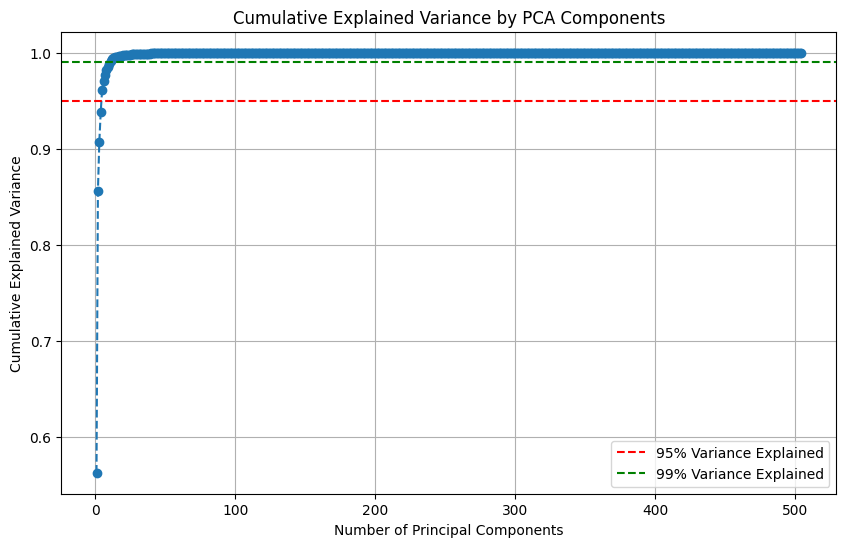

Number of components for 95% variance: 5
Number of components for 99% variance: 11


In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features_extracted_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker="o", linestyle="--")
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Explained")
plt.axhline(y=0.99, color="g", linestyle="--", label="99% Variance Explained")
plt.legend()
plt.grid()
plt.show()

# Print the number of components for 95% and 99% variance
components_95 = (cumulative_variance >= 0.95).argmax() + 1
components_99 = (cumulative_variance >= 0.99).argmax() + 1
print(f"Number of components for 95% variance: {components_95}")
print(f"Number of components for 99% variance: {components_99}")

In [6]:
# Perform PCA with the number of components that explain 95% of the variance
pca = PCA(n_components=components_95)
features_pca = pca.fit_transform(features_extracted_df)

# Reduce to 2D, and 3D for visualization
pca_2d = PCA(n_components=2).fit_transform(features_extracted_df)
pca_3d = PCA(n_components=3).fit_transform(features_extracted_df)
pca_reduction = {"2D": pca_2d, "3D": pca_3d}

print("Shape of PCA-transformed features:", features_pca.shape)
print("2D PCA-reduced features:", pca_2d.shape)
print("3D PCA-reduced features:", pca_3d.shape)

Shape of PCA-transformed features: (106574, 5)
2D PCA-reduced features: (106574, 2)
3D PCA-reduced features: (106574, 3)


### 2. Uniform Manifold Approximation and Projection (UMAP) <a class="anchor" id="2.2"></a>

In [7]:
import umap

# Apply UMAP for 2D and 3D
umap_2d = umap.UMAP(n_components=2).fit_transform(features_extracted_df)
umap_3d = umap.UMAP(n_components=3).fit_transform(features_extracted_df)

# Save UMAP results for visualization
umap_reduction = {"2D": umap_2d, "3D": umap_3d}
print("UMAP reduction results:")
print("2D shape:", umap_2d.shape)
print("3D shape:", umap_3d.shape)

c:\Users\suxro\source\Courses\CS6140\cs6140-assignments\assignments\.venv\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP reduction results:
2D shape: (106574, 2)
3D shape: (106574, 3)


In [8]:
# Take sample of random 10000 rows from the PCA-transformed features for visualization of TSNE, ISOMAP, and LLE
# Since those methods are computationally expensive, we will use a sample for visualization
sample_indices = np.random.choice(features_pca.shape[0], 10000, replace=False)
sampled_features = features_pca[sample_indices]

print("Sampled features shape:", sampled_features.shape)

Sampled features shape: (10000, 5)


### 3. t-Distributed Stochastic Neighbor Embedding (t-SNE) <a class="anchor" id="2.3"></a>

In [9]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D and 3D
tsne_2d = TSNE(n_components=2, n_jobs=-1).fit_transform(sampled_features)
tsne_3d = TSNE(n_components=3, n_jobs=-1).fit_transform(sampled_features)

# Save t-SNE results for visualization
tsne_reduction = {"2D": tsne_2d, "3D": tsne_3d}
print("TSNE reduction results:")
print("2D shape:", tsne_2d.shape)
print("3D shape:", tsne_3d.shape)

TSNE reduction results:
2D shape: (10000, 2)
3D shape: (10000, 3)


### 4. Locally Linear Embedding (LLE) <a class="anchor" id="2.4"></a>

In [10]:
from sklearn.manifold import LocallyLinearEmbedding

# Apply LLE for 2D and 3D
lle_2d = LocallyLinearEmbedding(n_components=2, n_jobs=-1).fit_transform(sampled_features)
lle_3d = LocallyLinearEmbedding(n_components=3, n_jobs=-1).fit_transform(sampled_features)

# Save LLE results for visualization
lle_reduction = {"2D": lle_2d, "3D": lle_3d}
print("LLE reduction results:")
print("2D shape:", lle_2d.shape)
print("3D shape:", lle_3d.shape)

LLE reduction results:
2D shape: (10000, 2)
3D shape: (10000, 3)


### 5. ISOMAP <a class="anchor" id="2.5"></a>

In [11]:
from sklearn.manifold import Isomap

# Apply ISOMAP for 2D and 3D
isomap_2d = Isomap(n_components=2, n_jobs=-1).fit_transform(sampled_features)
isomap_3d = Isomap(n_components=3, n_jobs=-1).fit_transform(sampled_features)

# Save ISOMAP results for visualization
isomap_reduction = {"2D": isomap_2d, "3D": isomap_3d}
print("ISOMAP reduction results:")
print("2D shape:", isomap_2d.shape)
print("3D shape:", isomap_3d.shape)

ISOMAP reduction results:
2D shape: (10000, 2)
3D shape: (10000, 3)


## Visualization <a class="anchor" id="3"></a>

### Extracting genre labels

In [12]:
# Ensure that the genres are properly cleaned and converted to categories
tracks_df["track_genre_top"] = tracks_df["track_genre_top"].astype("category")

# Drop NaN genres and align with features dataset
#tracks_with_genres = tracks_df.dropna(subset=["track_genre_top"])

features_with_genres = features_df.merge(
    tracks_df[["track_id", "track_genre_top"]], on="track_id"
)

# Extract updated genre labels after alignment
features_with_genres["genre_label"] = features_with_genres["track_genre_top"].cat.codes
features_with_genres["genre_name"] = features_with_genres["track_genre_top"]

# Map numeric labels back to genre names (for plotting purposes)
genre_mapping = dict(enumerate(tracks_df["track_genre_top"].cat.categories))

# Extract only the labels for visualization
genre_labels = features_with_genres["genre_label"].values
genre_names = features_with_genres["genre_name"].values

# Take a sample of 10,000 rows from both features and genre labels for visualization
sampled_genre_labels = genre_labels[sample_indices]

print("Genre mapping (numeric to name):", genre_mapping)
print("First few genre labels and names:")
display(features_with_genres[["genre_label", "genre_name"]].head())

print("Shape of features with genres:", features_with_genres.shape)
print("Sampled features shape:", sampled_features.shape)
print("Sampled genre labels shape:", sampled_genre_labels.shape)

Genre mapping (numeric to name): {0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Easy Listening', 4: 'Electronic', 5: 'Experimental', 6: 'Folk', 7: 'Hip-Hop', 8: 'Instrumental', 9: 'International', 10: 'Jazz', 11: 'Old-Time / Historic', 12: 'Pop', 13: 'Rock', 14: 'Soul-RnB', 15: 'Spoken'}
First few genre labels and names:


,genre_label,genre_name
0,7,Hip-Hop
1,7,Hip-Hop
2,7,Hip-Hop
3,12,Pop
4,-1,NaN


Shape of features with genres: (106574, 522)
Sampled features shape: (10000, 5)
Sampled genre labels shape: (10000,)


### 2D Visualization of Dimension Reduction Techniques

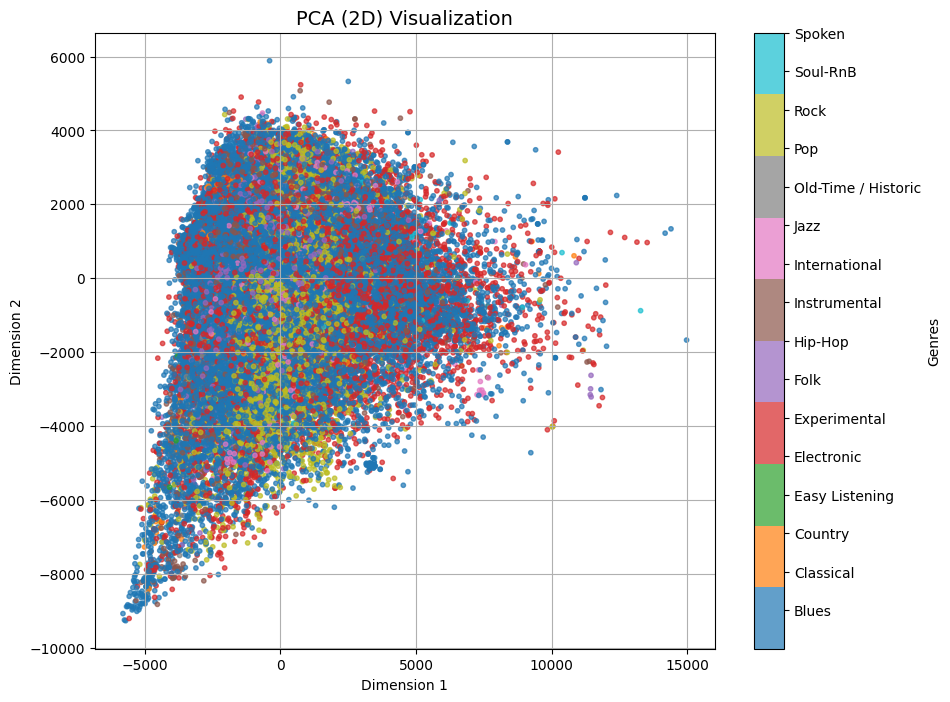

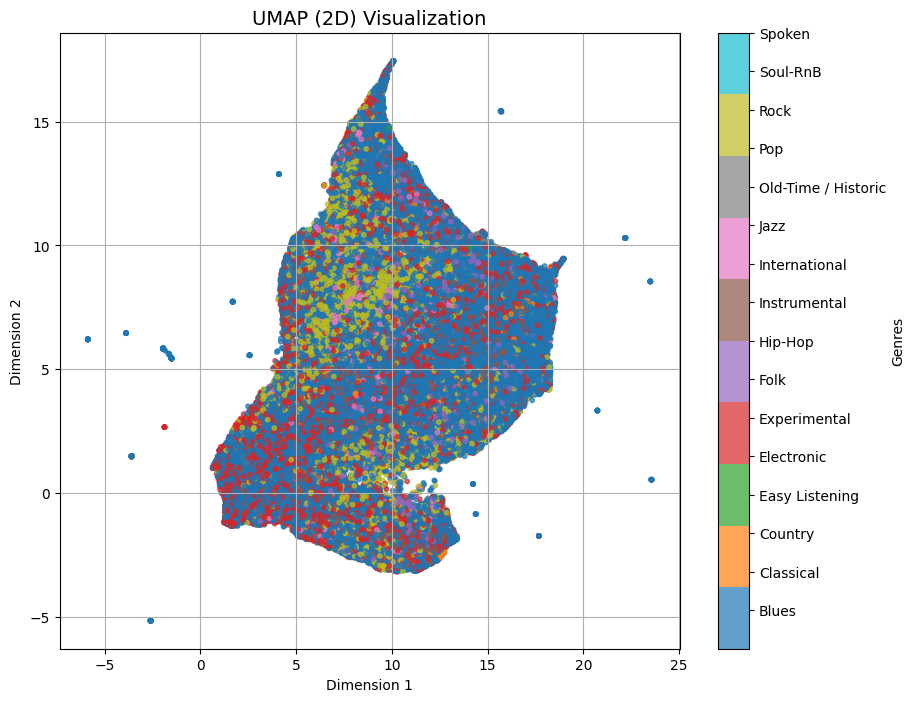

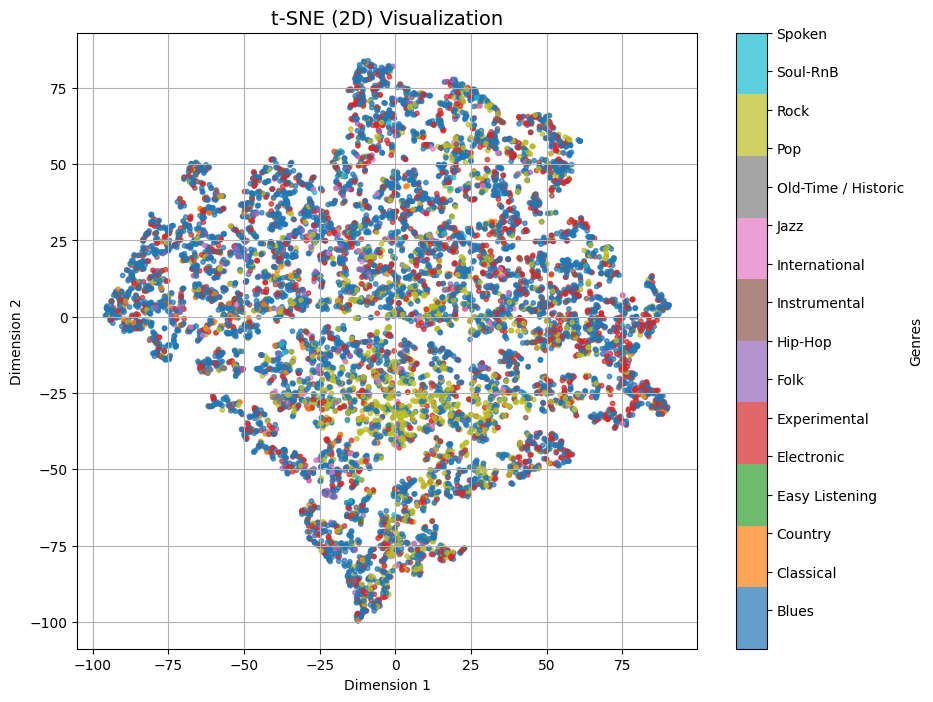

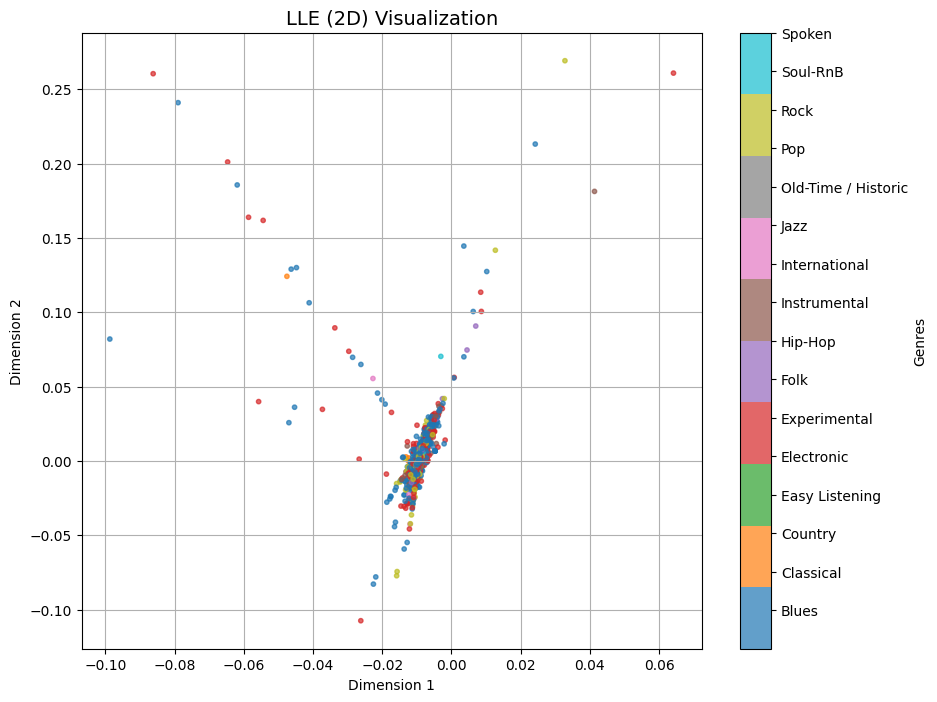

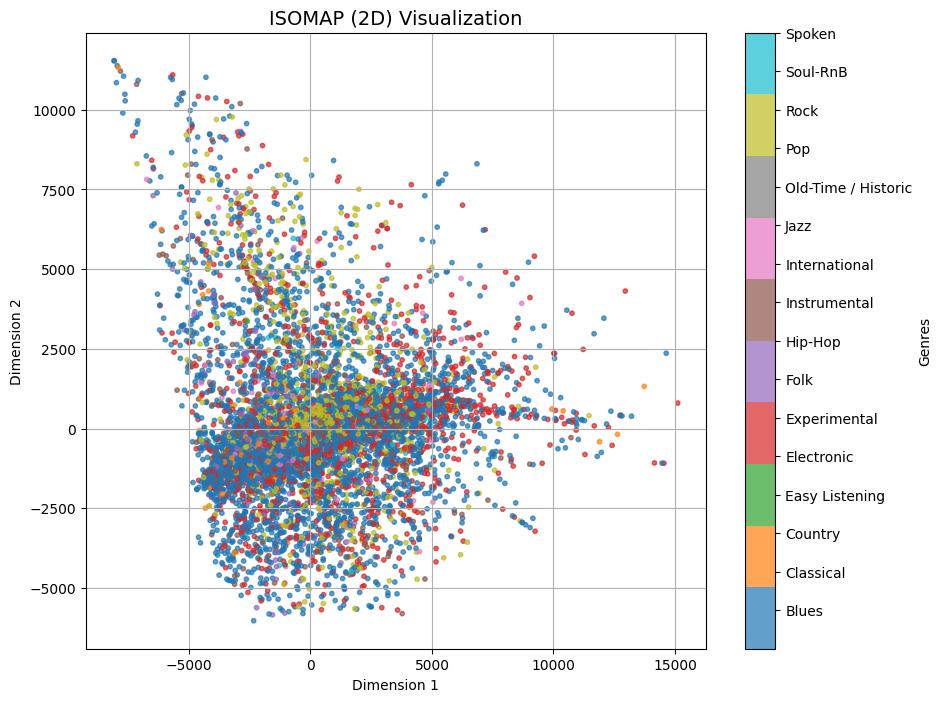

In [13]:
# Function to create a 2D scatter plot
def plot_2d_scatter(data: np.ndarray, labels, title: str) -> None:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(range(len(genre_mapping)))
    cbar.set_ticklabels(list(genre_mapping.values()))
    cbar.set_label("Genres")
    plt.title(title, fontsize=14)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Visualize 2D PCA
plot_2d_scatter(pca_reduction["2D"], genre_labels, "PCA (2D) Visualization")

# Visualize 2D UMAP
plot_2d_scatter(umap_reduction["2D"], genre_labels, "UMAP (2D) Visualization")

# Visualize 2D t-SNE
plot_2d_scatter(tsne_reduction["2D"], sampled_genre_labels, "t-SNE (2D) Visualization")

# Visualize 2D LLE
plot_2d_scatter(lle_reduction["2D"], sampled_genre_labels, "LLE (2D) Visualization")

# Visualize 2D ISOMAP
plot_2d_scatter(isomap_reduction["2D"], sampled_genre_labels, "ISOMAP (2D) Visualization")

### 3D Visualization of Dimension Reduction Techniques

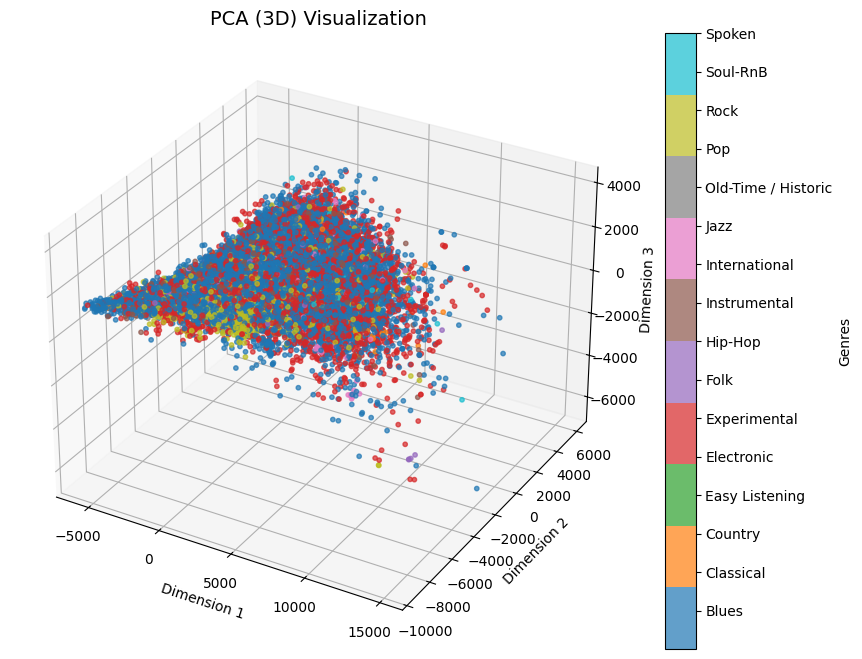

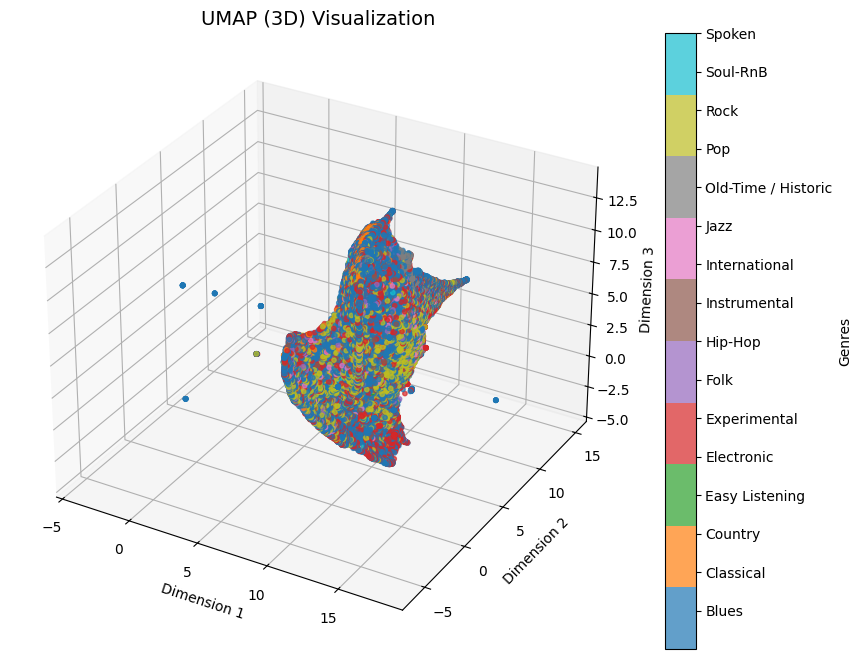

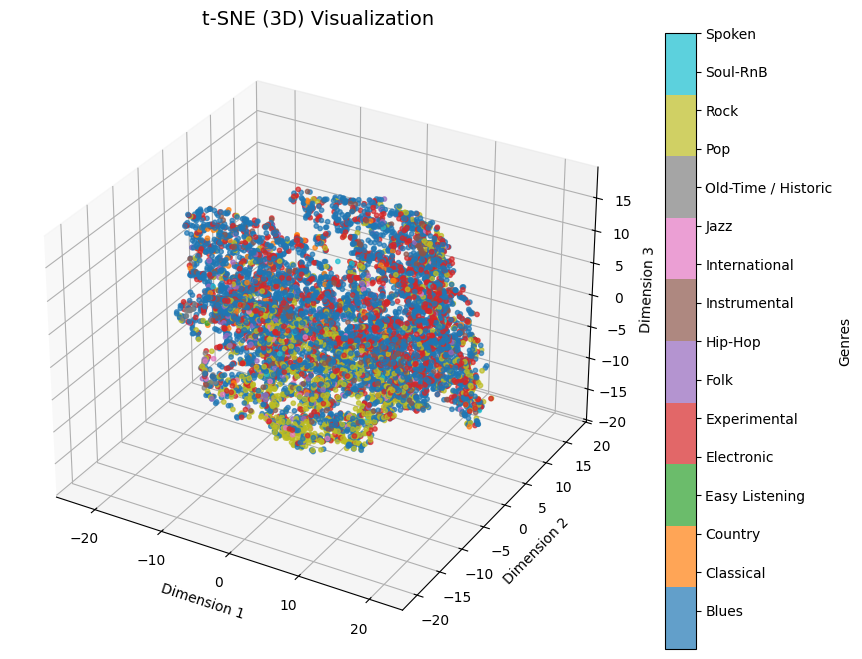

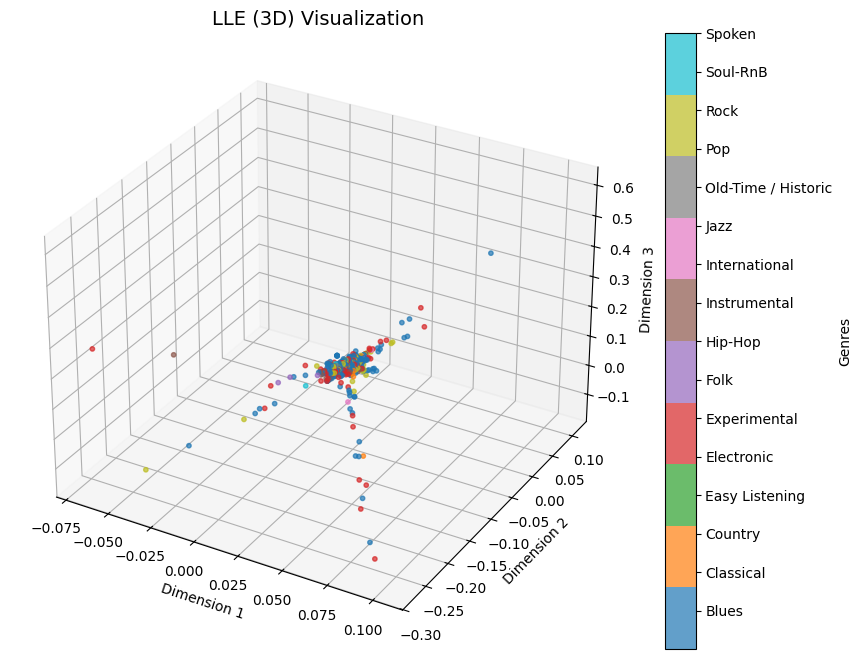

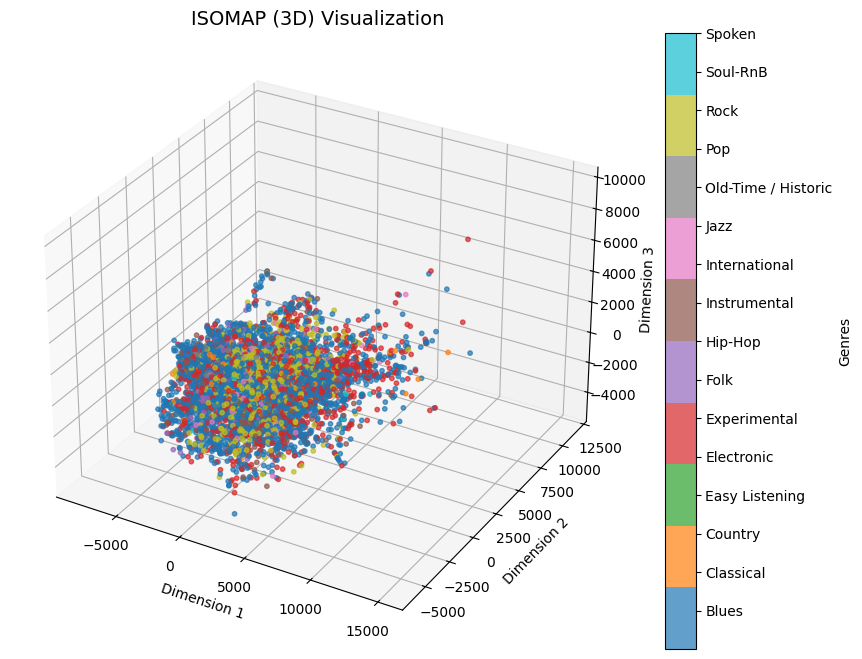

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Function to create a 3D scatter plot
def plot_3d_scatter(data: np.ndarray, labels, title: str) -> None:
    fig = plt.figure(figsize=(10, 8))
    ax: Axes3D = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="tab10", s=10, alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(range(len(genre_mapping)))
    cbar.set_ticklabels(list(genre_mapping.values()))
    cbar.set_label("Genres")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

# Visualize 3D PCA
plot_3d_scatter(pca_reduction["3D"], genre_labels, "PCA (3D) Visualization")

# Visualize 3D UMAP
plot_3d_scatter(umap_reduction["3D"], genre_labels, "UMAP (3D) Visualization")

# Visualize 3D t-SNE
plot_3d_scatter(tsne_reduction["3D"], sampled_genre_labels, "t-SNE (3D) Visualization")

# Visualize 3D LLE
plot_3d_scatter(lle_reduction["3D"], sampled_genre_labels, "LLE (3D) Visualization")

# Visualize 3D ISOMAP
plot_3d_scatter(isomap_reduction["3D"], sampled_genre_labels, "ISOMAP (3D) Visualization")

## Correlation Analysis <a class="anchor" id="4"></a>


Correlation Analysis for PCA (2D):


,PC1,PC2
PC1,1.000000e+00,-1.226834e-14
PC2,-1.226834e-14,1.000000e+00



Correlation Analysis for PCA (3D):


,PC1,PC2,PC3
PC1,1.000000e+00,-1.226834e-14,4.568958e-15
PC2,-1.226834e-14,1.000000e+00,2.877584e-14
PC3,4.568958e-15,2.877584e-14,1.000000e+00


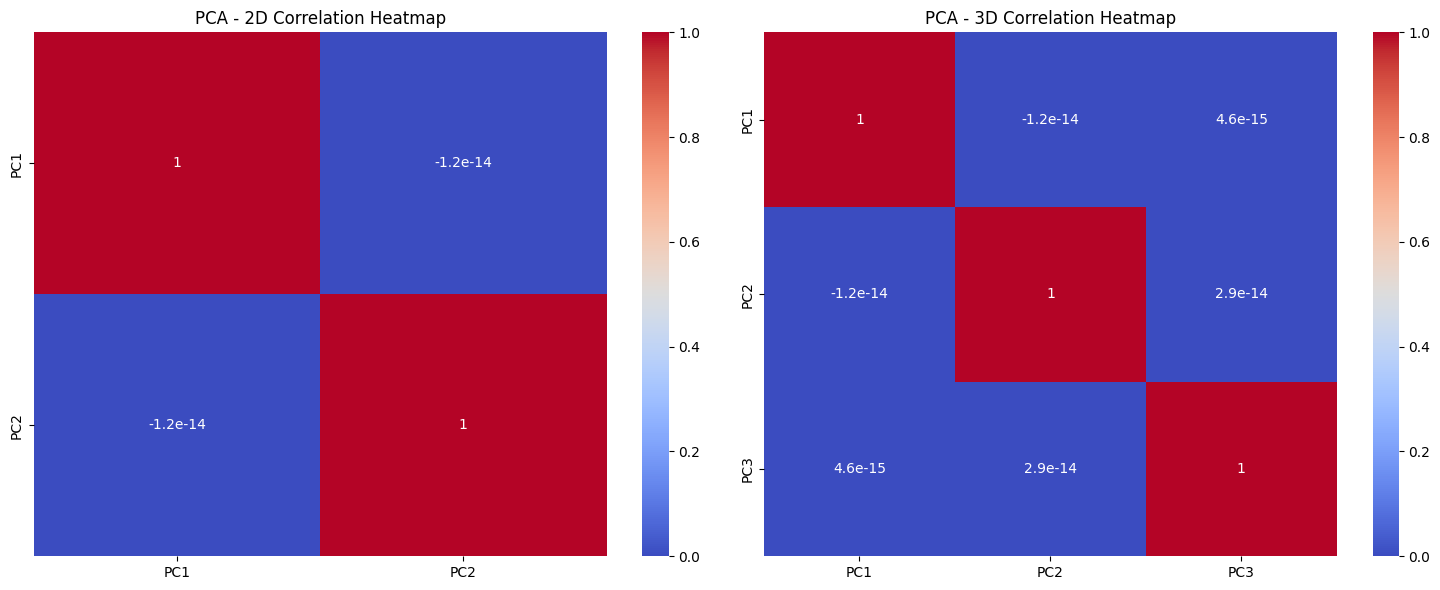


Correlation Analysis for UMAP (2D):


,UMAP1,UMAP2
UMAP1,1.000000,0.233874
UMAP2,0.233874,1.000000



Correlation Analysis for UMAP (3D):


,UMAP1,UMAP2,UMAP3
UMAP1,1.000000,0.355061,-0.049372
UMAP2,0.355061,1.000000,0.052861
UMAP3,-0.049372,0.052861,1.000000


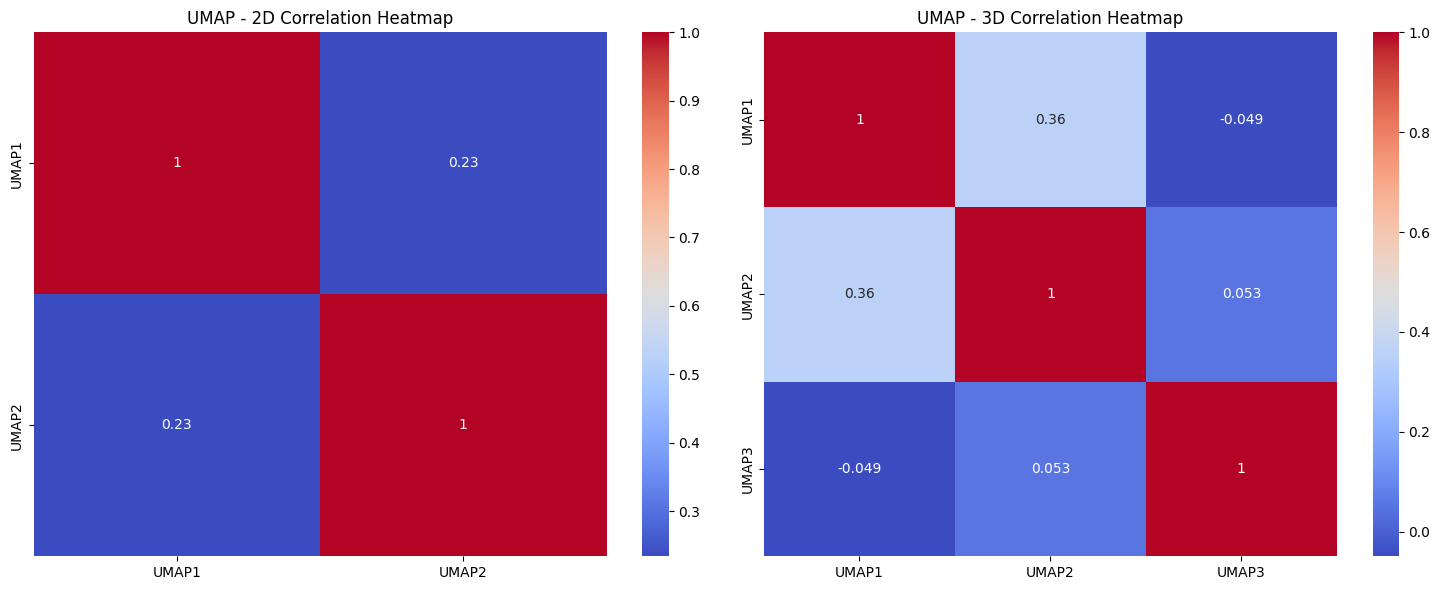


Correlation Analysis for t-SNE (2D):


,t-SNE1,t-SNE2
t-SNE1,1.000000,-0.022787
t-SNE2,-0.022787,1.000000



Correlation Analysis for t-SNE (3D):


,t-SNE1,t-SNE2,t-SNE3
t-SNE1,1.000000,-0.100091,0.015074
t-SNE2,-0.100091,1.000000,-0.133345
t-SNE3,0.015074,-0.133345,1.000000


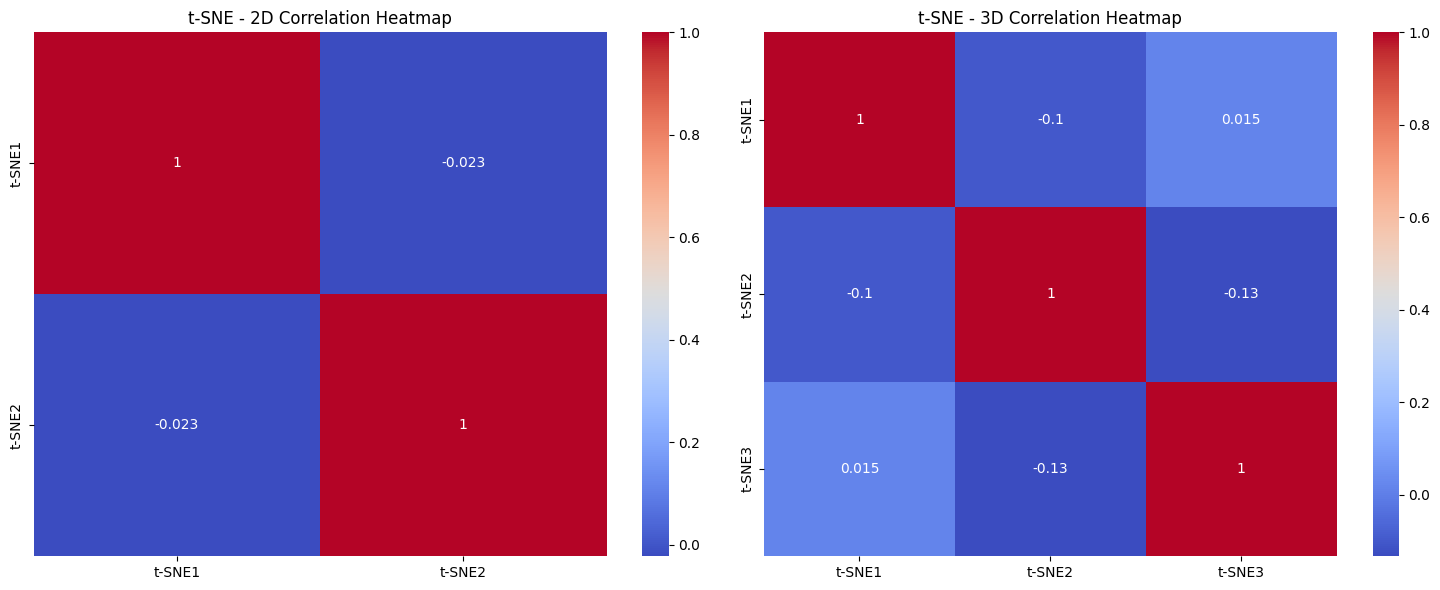


Correlation Analysis for LLE (2D):


,LLE1,LLE2
LLE1,1.000000,-0.014955
LLE2,-0.014955,1.000000



Correlation Analysis for LLE (3D):


,LLE1,LLE2,LLE3
LLE1,1.000000,-8.869896e-04,-2.187169e-03
LLE2,-0.000887,1.000000e+00,-1.486490e-07
LLE3,-0.002187,-1.486490e-07,1.000000e+00


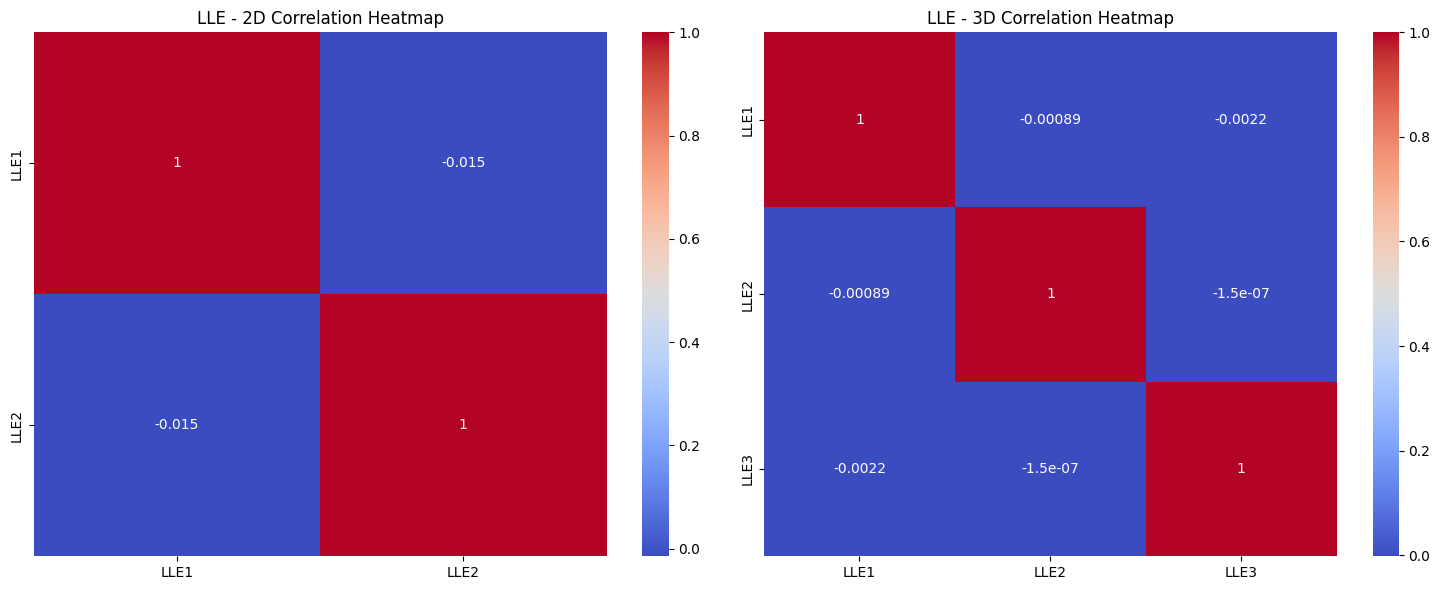


Correlation Analysis for ISOMAP (2D):


,ISOMAP1,ISOMAP2
ISOMAP1,1.000000e+00,2.217047e-16
ISOMAP2,2.217047e-16,1.000000e+00



Correlation Analysis for ISOMAP (3D):


,ISOMAP1,ISOMAP2,ISOMAP3
ISOMAP1,1.000000e+00,1.093309e-15,-4.364409e-16
ISOMAP2,1.093309e-15,1.000000e+00,-2.990191e-16
ISOMAP3,-4.364409e-16,-2.990191e-16,1.000000e+00


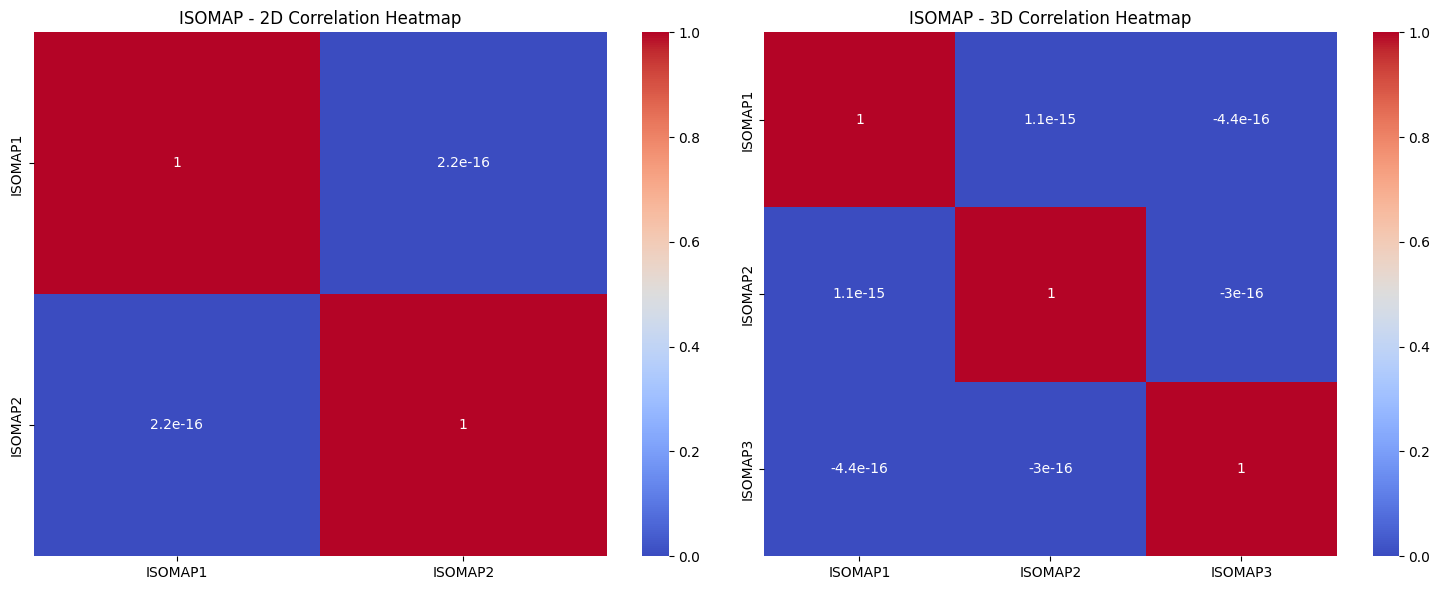

In [16]:
# Function to calculate and visualize correlations for reduced data
def analyze_correlations(data_2d: pd.DataFrame, data_3d: pd.DataFrame, method_name: str) -> None:
    print(f"\nCorrelation Analysis for {method_name} (2D):")
    corr_2d = data_2d.corr()
    display(corr_2d)

    print(f"\nCorrelation Analysis for {method_name} (3D):")
    corr_3d = data_3d.corr()
    display(corr_3d)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Heatmap for 2D correlations
    sns.heatmap(corr_2d, annot=True, cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"{method_name} - 2D Correlation Heatmap")
    
    # Heatmap for 3D correlations
    sns.heatmap(corr_3d, annot=True, cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"{method_name} - 3D Correlation Heatmap")
    
    plt.tight_layout()
    plt.show()

pca_2d_df = pd.DataFrame(pca_reduction["2D"], columns=["PC1", "PC2"])
pca_3d_df = pd.DataFrame(pca_reduction["3D"], columns=["PC1", "PC2", "PC3"])

umap_2d_df = pd.DataFrame(umap_reduction["2D"], columns=["UMAP1", "UMAP2"])
umap_3d_df = pd.DataFrame(umap_reduction["3D"], columns=["UMAP1", "UMAP2", "UMAP3"])

tsne_2d_df = pd.DataFrame(tsne_reduction["2D"], columns=["t-SNE1", "t-SNE2"])
tsne_3d_df = pd.DataFrame(tsne_reduction["3D"], columns=["t-SNE1", "t-SNE2", "t-SNE3"])

lle_2d_df = pd.DataFrame(lle_reduction["2D"], columns=["LLE1", "LLE2"])
lle_3d_df = pd.DataFrame(lle_reduction["3D"], columns=["LLE1", "LLE2", "LLE3"])

isomap_2d_df = pd.DataFrame(isomap_reduction["2D"], columns=["ISOMAP1", "ISOMAP2"])
isomap_3d_df = pd.DataFrame(isomap_reduction["3D"], columns=["ISOMAP1", "ISOMAP2", "ISOMAP3"])

# Analyze correlations for each method
analyze_correlations(pca_2d_df, pca_3d_df, "PCA")
analyze_correlations(umap_2d_df, umap_3d_df, "UMAP")
analyze_correlations(tsne_2d_df, tsne_3d_df, "t-SNE")
analyze_correlations(lle_2d_df, lle_3d_df, "LLE")
analyze_correlations(isomap_2d_df, isomap_3d_df, "ISOMAP")

### Correlation Analysis: Interpretation

From the outputs of the correlation analysis for each dimension reduction technique, the following can be inferred:

#### **Principal Component Analysis (PCA)**
- **2D Correlations**: Components are orthogonal (uncorrelated by design). Correlation values close to zero suggest no redundancy in dimensions.
- **3D Correlations**: Similarly, PCA maintains orthogonality across components. There are no significant patterns of correlation due to PCA’s design.

**Insight**: PCA creates components that maximize variance and ensures they are uncorrelated, making it ideal for preserving distinct dimensions.

#### **Uniform Manifold Approximation and Projection (UMAP)**
- **2D Correlations**: Moderate positive correlation (0.23) between dimensions indicates some redundancy or shared patterns.
- **3D Correlations**: Small correlations between dimensions indicate slight overlap, with UMAP1 and UMAP2 having a moderate positive relationship (0.35).

**Insight**: UMAP balances preserving global and local data structure but introduces small dependencies between dimensions.

#### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
- **2D Correlations**: Weak correlation (-0.02) suggests near-independence between dimensions.
- **3D Correlations**: Minimal correlations indicate low redundancy, but the lack of strong structure may mean t-SNE emphasizes local over global patterns.

**Insight**: t-SNE effectively separates local clusters but may underemphasize global relationships, reflected in weak correlations.

#### **Locally Linear Embedding (LLE)**
- **2D Correlations**: Almost no correlation (-0.01), showing low redundancy between dimensions.
- **3D Correlations**: Similarly, near-zero correlations confirm distinct dimensions without overlap.

**Insight**: LLE focuses on maintaining local neighborhood relationships, leading to nearly independent dimensions with minimal redundancy.

#### **ISOMAP**
- **2D Correlations**: Zero correlation (approximately) suggests independent dimensions.
- **3D Correlations**: Similar independence is observed with negligible correlations.

**Insight**: ISOMAP effectively preserves geodesic distances, ensuring distinct dimensions with little redundancy.

### Strong Correlations and Redundancy
- **PCA and ISOMAP**: Designed to minimize correlations between dimensions, making them ideal for applications requiring orthogonal components.
- **UMAP**: Introduces slight correlations due to its emphasis on both local and global structures.
- **t-SNE and LLE**: Focus on preserving local structures, with very weak correlations, suggesting a high degree of independence among dimensions.

### Redundancy Patterns
- Strong correlations would indicate overlapping information or redundancies, but none of the methods show significant issues in this regard. Each method balances dimensionality reduction while preserving distinct information effectively.

---

## Comparative Analysis <a class="anchor" id="5"></a>

Compare the effectiveness of each dimensionality reduction method in preserving the structure and patterns of the dataset. Here's how each method performs:

#### **Principal Component Analysis (PCA)**
- **Strengths**:
  - Preserves global variance and creates orthogonal dimensions.
  - High interpretability due to ordered components based on explained variance.
  - Computationally efficient for large datasets.
- **Limitations**:
  - Does not emphasize local structures (e.g., clusters within genres).
  - Linear transformations might miss nonlinear patterns.

**Best Use Case**: Situations where global structure and variance are key, such as preprocessing for machine learning models.

#### **Uniform Manifold Approximation and Projection (UMAP)**
- **Strengths**:
  - Balances local and global structure preservation.
  - Performs well in visualizing clusters (e.g., genres).
  - Faster than t-SNE for large datasets.
- **Limitations**:
  - Slight overlap in dimensions (as shown in correlations).
  - Sensitive to hyperparameter tuning (e.g., `n_neighbors`, `min_dist`).

**Best Use Case**: Visualizing clusters or patterns in high-dimensional data.

#### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
- **Strengths**:
  - Excellent at separating local clusters in 2D or 3D space.
  - Captures nuanced relationships within genres.
- **Limitations**:
  - Computationally expensive for large datasets.
  - Poor at preserving global structures (e.g., relationships between clusters).
  - Results may vary with different random initializations.

**Best Use Case**: Focused analysis of local relationships or small datasets.

#### **Locally Linear Embedding (LLE)**
- **Strengths**:
  - Preserves local neighborhood relationships effectively.
  - Works well for manifolds where data points lie on or near a smooth surface.
- **Limitations**:
  - Less effective at preserving global structures.
  - Computationally expensive for large datasets.

**Best Use Case**: Situations where local relationships are critical, and the dataset is relatively small.

#### **ISOMAP**
- **Strengths**:
  - Maintains geodesic distances, preserving global and local structures.
  - Effective for visualizing nonlinear manifolds.
- **Limitations**:
  - Computationally expensive for large datasets.
  - Sensitive to outliers or noise in the dataset.

**Best Use Case**: Datasets with nonlinear relationships where global structure preservation is key.

### Comparative Summary

| Method   | Preserves Global Structure | Preserves Local Structure | Computational Efficiency | Cluster Visualization | Key Weaknesses                 |
|----------|-----------------------------|---------------------------|---------------------------|-----------------------|--------------------------------|
| **PCA**  | High                        | Low                       | High                      | Moderate              | Misses nonlinear patterns      |
| **UMAP** | Moderate                    | High                      | Moderate                  | High                  | Sensitive to parameters        |
| **t-SNE**| Low                         | High                      | Low                       | High                  | Computationally expensive      |
| **LLE**  | Low                         | High                      | Low                       | Moderate              | Weak global structure          |
| **ISOMAP**| High                       | Moderate                  | Low                       | High                  | Sensitive to outliers          |


### Conclusion

- **PCA** is most suitable for reducing dimensions in preprocessing pipelines or when global structure is critical.
- **UMAP** offers a good balance between local and global structures, making it ideal for visualizations and cluster analysis.
- **t-SNE** excels in separating local clusters but is less effective at preserving the dataset's overall structure.
- **LLE** is well-suited for small datasets with a focus on local relationships.
- **ISOMAP** is effective for preserving nonlinear structures but is computationally intensive.

**Recommendation**:
For the FMA dataset:
- **UMAP** is preferred due to its balance of efficiency and meaningful data representation.
- **t-SNE** can be used for detailed cluster analysis on a sample of the dataset.